In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# === Paramètres ===
BATCH_SIZE = 128
NOISE_DIM = 64
EPOCHS = 300
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LR = 2e-4
SAVE_INTERVAL = 10



# === Dossiers ===
base_model_dir = "/content/drive/MyDrive/park_left"  # Poids préentraînés
fine_tune_model_dir = "/content/drive/MyDrive/park_left/saved_models_park_left"
sample_dir = "/content/drive/MyDrive/park_left/generated_samples_park_left"
data_path = "/content/drive/MyDrive/park_left/park_all_left.npz"

os.makedirs(fine_tune_model_dir, exist_ok=True)
os.makedirs(sample_dir, exist_ok=True)

# === Construction du générateur et du critic ===
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),

        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

def build_critic():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1200, 1)),

        tf.keras.layers.Conv1D(64, 15, strides=4, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv1D(128, 15, strides=4, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv1D(256, 15, strides=3, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)
    ])
    return model

# === Initialisation ===
generator = build_generator()
critic = build_critic()

generator_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)
critic_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)

# === Charger les poids préentraînés sur "controls" ===
generator.load_weights(f"{base_model_dir}/generator_epoch_250.weights.h5")
critic.load_weights(f"{base_model_dir}/critic_epoch_250.weights.h5")
print("✓ Poids préentraînés chargés depuis les sujets parkinson")

# === Chargement des données controls left ===
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1
data = data.astype(np.float32)

dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.shuffle(1000).batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

# === Gradient Penalty ===
def gradient_penalty(real, fake):
    batch_size = tf.shape(real)[0]
    alpha = tf.random.uniform([batch_size, 1, 1], 0., 1.)
    interpolated = real + alpha * (fake - real)

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = critic(interpolated, training=True)

    grads = tape.gradient(pred, [interpolated])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
    return tf.reduce_mean((slopes - 1.)**2)

# === Entraînement ===
fixed_noise = tf.random.normal([5, NOISE_DIM])
history = {'critic': [], 'gen': []}

def train_step(batch):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # Critic
    for _ in range(CRITIC_STEPS):
        with tf.GradientTape() as tape:
            fake = generator(noise, training=True)
            real_out = critic(batch, training=True)
            fake_out = critic(fake, training=True)

            gp = gradient_penalty(batch, fake)
            c_loss = tf.reduce_mean(fake_out) - tf.reduce_mean(real_out) + GP_WEIGHT * gp

        grads = tape.gradient(c_loss, critic.trainable_variables)
        critic_optimizer.apply_gradients(zip(grads, critic.trainable_variables))

    # Generator
    with tf.GradientTape() as tape:
        fake = generator(noise, training=True)
        g_loss = -tf.reduce_mean(critic(fake, training=True))

    grads = tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return c_loss, g_loss

# === Boucle d'entraînement ===
for epoch in range(EPOCHS):
    epoch_c_loss = []
    epoch_g_loss = []

    for batch in tqdm(dataset, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        c_loss, g_loss = train_step(batch)
        epoch_c_loss.append(c_loss)
        epoch_g_loss.append(g_loss)

    avg_c_loss = tf.reduce_mean(epoch_c_loss)
    avg_g_loss = tf.reduce_mean(epoch_g_loss)

    history['critic'].append(avg_c_loss.numpy())
    history['gen'].append(avg_g_loss.numpy())

    print(f"\nEpoch {epoch+1} | Critic: {avg_c_loss:.4f} | Generator: {avg_g_loss:.4f}")

    # Sauvegarde périodique
    if (epoch + 1) % SAVE_INTERVAL == 0:
        generator.save_weights(f'{fine_tune_model_dir}/generator_epoch_{epoch+1}.weights.h5')
        critic.save_weights(f'{fine_tune_model_dir}/critic_epoch_{epoch+1}.weights.h5')

        samples = generator(fixed_noise)
        plt.figure(figsize=(15, 3))
        for i in range(5):
            plt.subplot(5, 1, i+1)
            plt.plot(samples[i, :, 0])
            plt.ylim(-1, 1)
        plt.tight_layout()
        plt.savefig(f'{sample_dir}/epoch_{epoch+1}.png')
        plt.close()

print("✓ Fine-tuning terminé pour parkinson pied gauche")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


✓ Poids préentraînés chargés depuis les sujets parkinson


Epoch 1/300: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]



Epoch 1 | Critic: -1.3086 | Generator: -2.4527


Epoch 2/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 2 | Critic: -2.8918 | Generator: -1.8724


Epoch 3/300: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]



Epoch 3 | Critic: -2.9873 | Generator: 5.8926


Epoch 4/300: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 4 | Critic: -2.5316 | Generator: 8.8047


Epoch 5/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 5 | Critic: -1.6438 | Generator: -6.5959


Epoch 6/300: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]



Epoch 6 | Critic: -1.6554 | Generator: -9.7838


Epoch 7/300: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]



Epoch 7 | Critic: -1.6003 | Generator: -3.9874


Epoch 8/300: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]



Epoch 8 | Critic: -1.6048 | Generator: -4.7020


Epoch 9/300: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]



Epoch 9 | Critic: -1.4560 | Generator: -1.8489


Epoch 10/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 10 | Critic: -1.4878 | Generator: -0.8051


Epoch 11/300: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]



Epoch 11 | Critic: -1.5396 | Generator: 2.4745


Epoch 12/300: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]



Epoch 12 | Critic: -1.5111 | Generator: 5.4770


Epoch 13/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 13 | Critic: -1.4627 | Generator: 5.7885


Epoch 14/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 14 | Critic: -1.9595 | Generator: 1.8791


Epoch 15/300: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]



Epoch 15 | Critic: -1.7640 | Generator: 2.1320


Epoch 16/300: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 16 | Critic: -1.7039 | Generator: 0.6789


Epoch 17/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 17 | Critic: -1.4614 | Generator: -0.7374


Epoch 18/300: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]



Epoch 18 | Critic: -1.6626 | Generator: 1.7966


Epoch 19/300: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 19 | Critic: -1.7431 | Generator: 3.7632


Epoch 20/300: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 20 | Critic: -1.6999 | Generator: 5.0575


Epoch 21/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 21 | Critic: -1.6092 | Generator: 5.2076


Epoch 22/300: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]



Epoch 22 | Critic: -1.6435 | Generator: 2.8529


Epoch 23/300: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]



Epoch 23 | Critic: -1.6005 | Generator: 2.9923


Epoch 24/300: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 24 | Critic: -1.8061 | Generator: 5.8922


Epoch 25/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 25 | Critic: -1.5168 | Generator: 2.2557


Epoch 26/300: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]



Epoch 26 | Critic: -1.8084 | Generator: 3.6827


Epoch 27/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 27 | Critic: -1.5234 | Generator: 5.1478


Epoch 28/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 28 | Critic: -1.5329 | Generator: 8.3964


Epoch 29/300: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]



Epoch 29 | Critic: -1.6404 | Generator: 0.6325


Epoch 30/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 30 | Critic: -1.5806 | Generator: -3.5335


Epoch 31/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 31 | Critic: -1.5556 | Generator: 0.2332


Epoch 32/300: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]



Epoch 32 | Critic: -1.7551 | Generator: -0.2172


Epoch 33/300: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]



Epoch 33 | Critic: -1.6390 | Generator: -0.9370


Epoch 34/300: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 34 | Critic: -1.5249 | Generator: 3.4578


Epoch 35/300: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]



Epoch 35 | Critic: -1.9077 | Generator: -1.1151


Epoch 36/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 36 | Critic: -1.5264 | Generator: -2.2888


Epoch 37/300: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]



Epoch 37 | Critic: -1.5885 | Generator: -3.1968


Epoch 38/300: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 38 | Critic: -1.6772 | Generator: 4.1686


Epoch 39/300: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]



Epoch 39 | Critic: -1.5465 | Generator: 2.8198


Epoch 40/300: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]



Epoch 40 | Critic: -1.6867 | Generator: -2.0194


Epoch 41/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 41 | Critic: -1.7088 | Generator: -1.7430


Epoch 42/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 42 | Critic: -1.6149 | Generator: -2.3369


Epoch 43/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 43 | Critic: -1.6901 | Generator: 0.3250


Epoch 44/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 44 | Critic: -1.6515 | Generator: 0.4720


Epoch 45/300: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]



Epoch 45 | Critic: -1.5933 | Generator: 2.0882


Epoch 46/300: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]



Epoch 46 | Critic: -1.5943 | Generator: 1.1551


Epoch 47/300: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]



Epoch 47 | Critic: -1.5624 | Generator: 5.0041


Epoch 48/300: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]



Epoch 48 | Critic: -1.5837 | Generator: 5.9644


Epoch 49/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 49 | Critic: -1.5346 | Generator: 1.1333


Epoch 50/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 50 | Critic: -1.6861 | Generator: 3.0311


Epoch 51/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 51 | Critic: -1.8608 | Generator: 5.9698


Epoch 52/300: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]



Epoch 52 | Critic: -1.3627 | Generator: -5.3591


Epoch 53/300: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]



Epoch 53 | Critic: -1.4650 | Generator: 2.3721


Epoch 54/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 54 | Critic: -1.3773 | Generator: 4.5427


Epoch 55/300: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]



Epoch 55 | Critic: -1.5079 | Generator: -6.0315


Epoch 56/300: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 56 | Critic: -1.5177 | Generator: 1.6804


Epoch 57/300: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]



Epoch 57 | Critic: -1.6017 | Generator: 3.9905


Epoch 58/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 58 | Critic: -1.5830 | Generator: 0.7432


Epoch 59/300: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]



Epoch 59 | Critic: -1.5460 | Generator: 1.3215


Epoch 60/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 60 | Critic: -1.3188 | Generator: 3.8490


Epoch 61/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 61 | Critic: -1.7144 | Generator: 11.8166


Epoch 62/300: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]



Epoch 62 | Critic: -1.1856 | Generator: 4.5109


Epoch 63/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 63 | Critic: -1.5734 | Generator: 3.3705


Epoch 64/300: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 64 | Critic: -1.5378 | Generator: 3.5413


Epoch 65/300: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]



Epoch 65 | Critic: -1.3643 | Generator: 4.7545


Epoch 66/300: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]



Epoch 66 | Critic: -1.4190 | Generator: 2.3717


Epoch 67/300: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]



Epoch 67 | Critic: -1.4826 | Generator: 2.1409


Epoch 68/300: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 68 | Critic: -1.5510 | Generator: 2.9872


Epoch 69/300: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]



Epoch 69 | Critic: -1.4383 | Generator: 2.0823


Epoch 70/300: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]



Epoch 70 | Critic: -1.4509 | Generator: 2.6647


Epoch 71/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 71 | Critic: -1.4753 | Generator: 4.9207


Epoch 72/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 72 | Critic: -1.2793 | Generator: 1.8816


Epoch 73/300: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]



Epoch 73 | Critic: -1.4254 | Generator: 3.5996


Epoch 74/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 74 | Critic: -1.3997 | Generator: 2.4471


Epoch 75/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 75 | Critic: -1.4044 | Generator: 2.9468


Epoch 76/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 76 | Critic: -1.2060 | Generator: 6.3267


Epoch 77/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 77 | Critic: -1.5559 | Generator: 8.3020


Epoch 78/300: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 78 | Critic: -1.4976 | Generator: 6.2867


Epoch 79/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 79 | Critic: -1.1668 | Generator: 2.5455


Epoch 80/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 80 | Critic: -1.3669 | Generator: 1.4655


Epoch 81/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 81 | Critic: -1.2990 | Generator: 5.2335


Epoch 82/300: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]



Epoch 82 | Critic: -1.3966 | Generator: 3.6082


Epoch 83/300: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]



Epoch 83 | Critic: -1.2123 | Generator: 0.6602


Epoch 84/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 84 | Critic: -1.5024 | Generator: -0.9122


Epoch 85/300: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 85 | Critic: -1.5927 | Generator: -2.9111


Epoch 86/300: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]



Epoch 86 | Critic: -1.3559 | Generator: -2.2302


Epoch 87/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 87 | Critic: -1.2928 | Generator: -0.6820


Epoch 88/300: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]



Epoch 88 | Critic: -1.5454 | Generator: 5.1260


Epoch 89/300: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 89 | Critic: -1.4308 | Generator: 4.3711


Epoch 90/300: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]



Epoch 90 | Critic: -1.4814 | Generator: -2.1931


Epoch 91/300: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]



Epoch 91 | Critic: -1.4166 | Generator: -4.3930


Epoch 92/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 92 | Critic: -1.4644 | Generator: -3.9031


Epoch 93/300: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]



Epoch 93 | Critic: -1.3654 | Generator: -6.8796


Epoch 94/300: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 94 | Critic: -1.1658 | Generator: -9.3869


Epoch 95/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 95 | Critic: -1.2268 | Generator: -5.8909


Epoch 96/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 96 | Critic: -1.1631 | Generator: -2.4817


Epoch 97/300: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]



Epoch 97 | Critic: -1.3831 | Generator: -5.5687


Epoch 98/300: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 98 | Critic: -1.3608 | Generator: -4.9244


Epoch 99/300: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]



Epoch 99 | Critic: -1.5513 | Generator: -2.4551


Epoch 100/300: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 100 | Critic: -1.4762 | Generator: -5.8153


Epoch 101/300: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]



Epoch 101 | Critic: -1.2675 | Generator: -2.7284


Epoch 102/300: 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]



Epoch 102 | Critic: -1.5192 | Generator: -7.3451


Epoch 103/300: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]



Epoch 103 | Critic: -1.4775 | Generator: -1.3636


Epoch 104/300:  40%|████      | 6/15 [00:05<00:07,  1.18it/s]


KeyboardInterrupt: 

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')  # Suppress general warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow INFO and WARNING messages

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


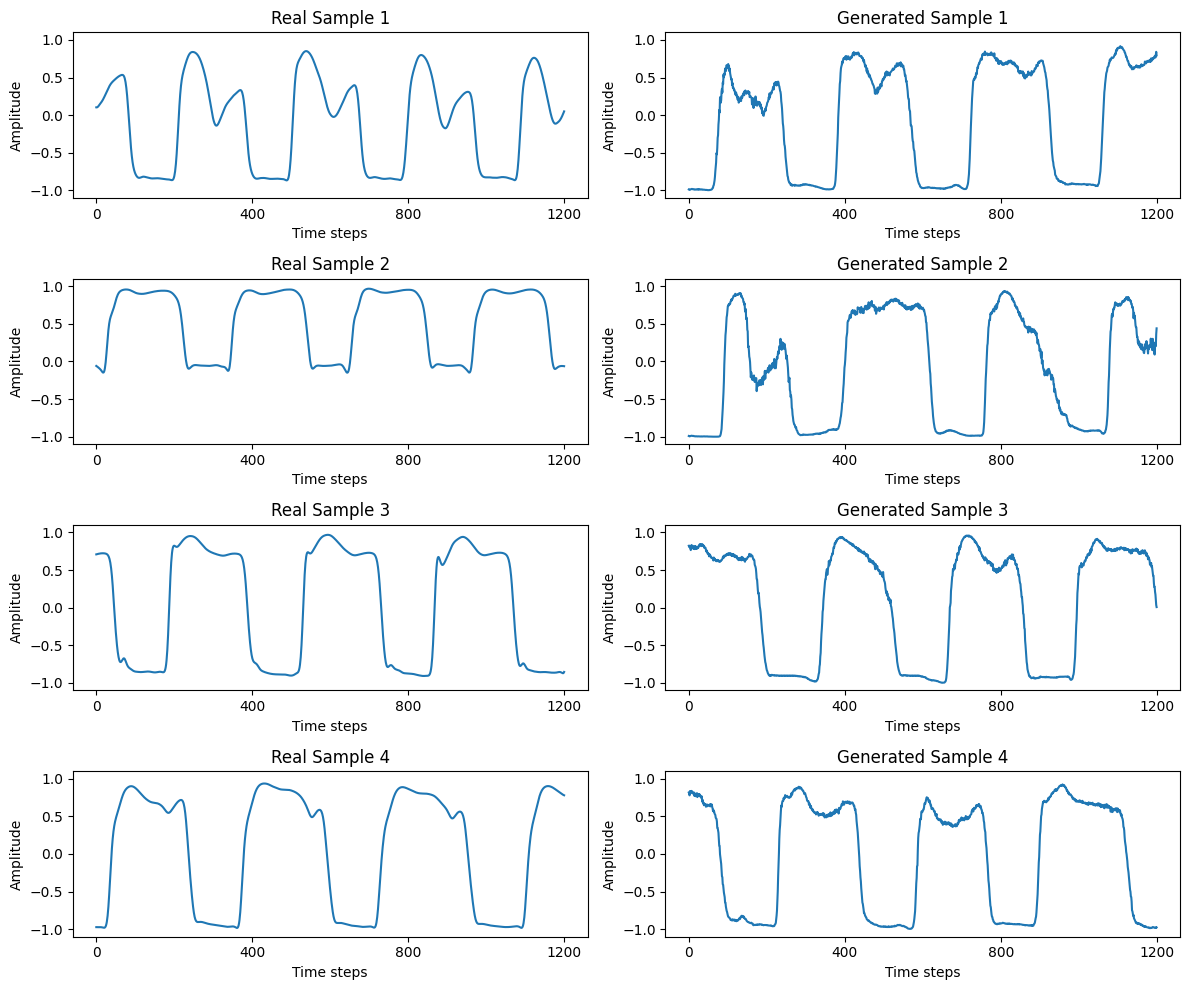

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt




# Parameters
NOISE_DIM = 64
num_samples = 4  # Match the number of samples in your image

# Define generator (same as in your training code)
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),
        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

# Load real data
data_path = "/content/drive/MyDrive/park_left/park_all_left.npz"
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1  # Normalize to [-1, 1]
real_samples = data[np.random.choice(data.shape[0], num_samples, replace=False)]

# Load generator
generator = build_generator()
generator.load_weights('/content/drive/MyDrive/park_left/saved_models_park_left/generator_epoch_100.weights.h5')

# Generate samples
fixed_noise = tf.random.normal([num_samples, NOISE_DIM])
generated_samples = generator(fixed_noise, training=False).numpy()

# Plotting
plt.figure(figsize=(12, 10))

for i in range(num_samples):
    # Real Sample
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.plot(real_samples[i, :])
    plt.title(f'Real Sample {i+1}')
    plt.xlabel('Time steps')
    plt.ylabel('Amplitude')
    plt.ylim(-1.1, 1.1)
    plt.xticks([0, 400, 800, 1200])

    # Generated Sample
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.plot(generated_samples[i, :, 0])
    plt.title(f'Generated Sample {i+1}')
    plt.xlabel('Time steps')
    plt.ylabel('Amplitude')
    plt.ylim(-1.1, 1.1)
    plt.xticks([0, 400, 800, 1200])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📏 MMD Score: 0.020029819429472035
🔄 Average DTW Distance: 11.806694348895384
🔁 Average Cross-Correlation: -0.014641777967845167


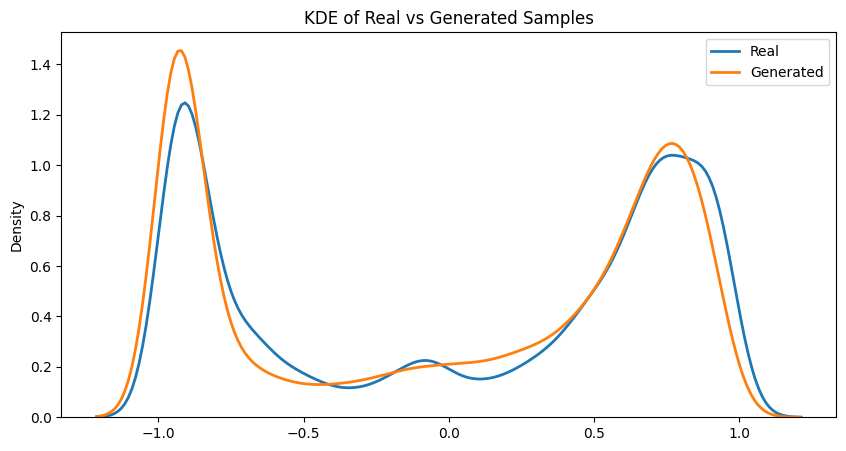

In [ ]:
!pip install dtaidistance

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
from dtaidistance import dtw
import seaborn as sns

# --- Paramètres ---
NOISE_DIM = 64
num_samples = 100  # Nombre d'échantillons à comparer

# --- Chargement des données réelles ---
data_path = "/content/drive/MyDrive/park_left/park_all_left.npz"
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1
real_samples = data[np.random.choice(data.shape[0], num_samples, replace=False)]

# --- Générateur ---
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),
        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

# --- Chargement du générateur préentraîné ---
generator = build_generator()
generator.load_weights('/content/drive/MyDrive/park_left/saved_models_park_left/generator_epoch_100.weights.h5')

# --- Génération des échantillons ---
fixed_noise = tf.random.normal([num_samples, NOISE_DIM])
generated_samples = generator(fixed_noise, training=False).numpy()

# --- MMD ---
def compute_mmd(x, y, gamma=1.0):
    xx = rbf_kernel(x, x, gamma=gamma)
    yy = rbf_kernel(y, y, gamma=gamma)
    xy = rbf_kernel(x, y, gamma=gamma)
    return np.mean(xx) + np.mean(yy) - 2 * np.mean(xy)

real_flat = real_samples.reshape(real_samples.shape[0], -1)
fake_flat = generated_samples.reshape(generated_samples.shape[0], -1)

mmd_score = compute_mmd(real_flat, fake_flat, gamma=0.1)
print("📏 MMD Score:", mmd_score)

# --- DTW ---
def compute_average_dtw(real_samples, generated_samples):
    dtw_distances = []
    for r, g in zip(real_samples, generated_samples):
        dist = dtw.distance(r.flatten(), g.flatten())
        dtw_distances.append(dist)
    return np.mean(dtw_distances)

dtw_score = compute_average_dtw(real_samples, generated_samples)
print("🔄 Average DTW Distance:", dtw_score)

# --- Cross-Correlation ---
def cross_correlation(a, b):
    a = (a - np.mean(a)) / (np.std(a) + 1e-8)
    b = (b - np.mean(b)) / (np.std(b) + 1e-8)
    return np.correlate(a, b, mode='valid')[0] / len(a)

ccs = [cross_correlation(r.flatten(), g.flatten()) for r, g in zip(real_samples, generated_samples)]
print("🔁 Average Cross-Correlation:", np.mean(ccs))

# --- Visualisation KDE ---
plt.figure(figsize=(10, 5))
sns.kdeplot(real_samples.reshape(-1), label="Real", linewidth=2)
sns.kdeplot(generated_samples.reshape(-1), label="Generated", linewidth=2)
plt.legend()
plt.title("KDE of Real vs Generated Samples")
plt.show()